#Project: Offensive Speech Classification

The work involves classification of text as either Offensive (OFF) or not offensive (NOT).The following were performed on the data:
- Loading of data
- Split trainset into four subset [25%,50%,75% and 100%]. Each subset was used to train the model with the valid and text set for validation and testing of the model
- Data preprocessing with more details in Section 3
- Models: Two methods are utilized. 
  - The machine learning technique which uses the XGBClassifier() to classify and predict text as either OFF or NOT. The 
  - The MLP model

 


Loading the gdrive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Install required module if not already installed

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's import all require libraries. 

In [4]:
import numpy as np
import os
import pandas as pd

#module for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import io 
import preprocessor as p
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split,cross_val_score
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score,classification_report, precision_score, recall_score
import torch
import torch.nn as nn

import pickle 

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Adding 2209506 as a variable and set as seed

In [6]:
my_seed = 2209506

Setting the `seed` for all required libraries with my student id

In [ ]:
#numpy seed
np.random.seed(my_seed)
torch.manual_seed(my_seed)
torch.cuda.manual_seed(my_seed)

# The following will be performed in this section
*   Data read
*   Split train set into 4 subsets
*   Data preprocessing
*   Performance Metrics
*   Saving model and output
*   Loading Model and output




Dividing only the training dataset into 4 equal subsets [25%,50%,75% and 100%] and save it in the GDrive.

###1. Read the whole train dataset

In [8]:
train = pd.read_csv("/content/gdrive/MyDrive/CE807/Assignment2/2209506/train.csv")

### 2. Split the train dataset into 4 subsets [25%, 50%, 75% and 100%]

In [9]:
# Split the data into 25% train and 75% test
train_1, test_75 = train_test_split(train, test_size=0.75, random_state=42, stratify = train['label'])

# Split the remaining 75% test data into 33% train and 67% test
train_2, test_67 = train_test_split(test_75, test_size=0.67, random_state=42, stratify = test_75['label'])

# Split the remaining test data into equal parts
train_3, train_4 = train_test_split(test_67, test_size=0.5, random_state=42, stratify = test_67['label'])

# Combine train_1, train_2, train_3, and train_4 to get 25%, 50%, 75%, and 100% train data
train_25 = train_1
train_25.to_csv('/content/gdrive/MyDrive/CE807/Assignment2/2209506/train_25.csv',index_label = False)
train_50 = pd.concat([train_1, train_2])
train_50.to_csv('/content/gdrive/MyDrive/CE807/Assignment2/2209506/train_50.csv',index_label = False)
train_75 = pd.concat([train_1, train_2, train_3])
train_75.to_csv('/content/gdrive/MyDrive/CE807/Assignment2/2209506/train_75.csv',index_label = False)
train_100 = pd.concat([train_1, train_2, train_3, train_4])
train_100.to_csv('/content/gdrive/MyDrive/CE807/Assignment2/2209506/train_100.csv',index_label = False)

#### 2a: Allowing the GDrive access and setting data and model paths

In [10]:
 GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join('./CE807/Assignment2/',str(student_id))
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))


List files:  ['code.ipynb', 'valid.csv', 'test.csv', 'train_25.csv', 'train.csv', 'train_50.csv', 'train_100.csv', 'train_75.csv', 'models']


#### 2b:Locating the file names and printing them

In [11]:
train_100_file = os.path.join(GOOGLE_DRIVE_PATH, 'train_100.csv') # This is 100% of data
train_25_file = os.path.join(GOOGLE_DRIVE_PATH, 'train_25.csv')
train_50_file = os.path.join(GOOGLE_DRIVE_PATH, 'train_50.csv') 
train_75_file = os.path.join(GOOGLE_DRIVE_PATH, 'train_75.csv')
val_file = os.path.join(GOOGLE_DRIVE_PATH, 'valid.csv')
test_file = os.path.join(GOOGLE_DRIVE_PATH, 'test.csv')

print('Train 25% file: ', train_25_file)
print('Train 25% file: ', train_50_file)
print('Train 25% file: ', train_75_file)
print('Train 100% file: ', train_100_file)
print('Validation file: ', val_file)
print('Test file: ', test_file)

Train 25% file:  gdrive/MyDrive/./CE807/Assignment2/2209506/train_25.csv
Train 25% file:  gdrive/MyDrive/./CE807/Assignment2/2209506/train_50.csv
Train 25% file:  gdrive/MyDrive/./CE807/Assignment2/2209506/train_75.csv
Train 100% file:  gdrive/MyDrive/./CE807/Assignment2/2209506/train_100.csv
Validation file:  gdrive/MyDrive/./CE807/Assignment2/2209506/valid.csv
Test file:  gdrive/MyDrive/./CE807/Assignment2/2209506/test.csv


### Function to for total count and value_counts of each dataset

In [12]:
def count_each_csv(column_name, folder_path):
    
    # Loop through all CSV files in folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            # Construct full path to CSV file
            file_path = os.path.join(folder_path, file_name)
            
            # Read in data as a dataframe
            df = pd.read_csv(file_path)
            
            # Get total entries and count of unique values in column
            value_counts = df[column_name].value_counts()
            value_counts_percent = round(df[column_name].value_counts(1)*100,2)
            count = df[column_name].count()
            
            
            # Create a new dataframe with count and value_counts columns
            df_counts = pd.DataFrame({'Value Count': value_counts.values,'%count': value_counts_percent.values, column_name: value_counts.index})
            
            # Print count and the dataframe
            print(f"Dataframe for {file_name}:")
            print('total entries: ', count)
            print(df_counts)
            print('\n')

Print the total entries and value counts of label column

In [13]:
count_each_csv('label', GOOGLE_DRIVE_PATH)

Dataframe for valid.csv:
total entries:  927
   Value Count  %count label
0          619   66.77   NOT
1          308   33.23   OFF


Dataframe for test.csv:
total entries:  860
   Value Count  %count label
0          620   72.09   NOT
1          240   27.91   OFF


Dataframe for train_25.csv:
total entries:  3078
   Value Count  %count label
0         2055   66.76   NOT
1         1023   33.24   OFF


Dataframe for train.csv:
total entries:  12313
   Value Count  %count label
0         8221   66.77   NOT
1         4092   33.23   OFF


Dataframe for train_50.csv:
total entries:  6125
   Value Count  %count label
0         4089   66.76   NOT
1         2036   33.24   OFF


Dataframe for train_100.csv:
total entries:  12313
   Value Count  %count label
0         8221   66.77   NOT
1         4092   33.23   OFF


Dataframe for train_75.csv:
total entries:  9219
   Value Count  %count label
0         6155   66.76   NOT
1         3064   33.24   OFF




#### 2c: Setting the output model directory and file names.

In [14]:
MODEL_1_DIRECTORY = os.path.join(GOOGLE_DRIVE_PATH, 'models', '1') # Model 1 directory
print('Model 1 directory: ', MODEL_1_DIRECTORY)

MODEL_1_25_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'25') # Model 1 trained using 25% of train data directory
print('Model 1 directory with 25% data: ', MODEL_1_25_DIRECTORY)

MODEL_1_50_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'50') # Model 1 trained using 50% of train data directory
print('Model 1 directory with 50% data: ', MODEL_1_50_DIRECTORY)

MODEL_1_75_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'75') # Model 1 trained using 25% of train data directory
print('Model 1 directory with 75% data: ', MODEL_1_25_DIRECTORY)

MODEL_1_100_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'100') # Model 1 trained using 100% of train data directory
print('Model 1 directory with 100% data: ', MODEL_1_100_DIRECTORY)


model_1_25_output_test_file = os.path.join(MODEL_1_25_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 25% of train data 
print('Output file name using model 1 using 25% of train data: ',model_1_25_output_test_file)

model_1_50_output_test_file = os.path.join(MODEL_1_50_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 50% of train data 
print('Output file name using model 1 using 50% of train data: ',model_1_50_output_test_file)

model_1_75_output_test_file = os.path.join(MODEL_1_75_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 75% of train data 
print('Output file name using model 1 using 75% of train data: ',model_1_75_output_test_file)

model_1_100_output_test_file = os.path.join(MODEL_1_100_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 25% of train data 
print('Output file name using model 1 using 100% of train data: ',model_1_100_output_test_file)


# You need to do this for both models and all data sizes 

Model 1 directory:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1
Model 1 directory with 25% data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/25
Model 1 directory with 50% data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/50
Model 1 directory with 75% data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/25
Model 1 directory with 100% data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/100
Output file name using model 1 using 25% of train data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/25/output_test.csv
Output file name using model 1 using 50% of train data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/50/output_test.csv
Output file name using model 1 using 75% of train data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/75/output_test.csv
Output file name using model 1 using 100% of train data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/100/output_test.csv


Let's see train file

In [15]:
df = pd.read_csv(train_100_file)
df.head()

,id,tweet,label
165,37685,@USER He is a coward.,OFF
4467,81613,@USER Glad to see your friends are supporting ...,NOT
10215,61117,@USER Glad you are the same person. Keep up th...,NOT
10458,70789,Mark Judge doesn't want to lie for KAVANAUGH. ...,NOT
9304,28193,@USER A person’s stance on gun control is a te...,NOT


### 3. Data Preprocessing

We are dealing with tweets data and there is need for some data preprocessing
- Tweets may contain URL's, Mentions, Hashtags, Emojis, Smileys and Spefic words 
- We use the python library 'tweet-preprocessor' to clean the tweet
- We carry out other data cleaning such as 
  - Lowercasing
  - Punctuation Removal
  - Replace extra white spaces
  - Stopwords removal
  -Stemming

In [16]:
ps = PorterStemmer()

In [17]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def clean_tweet(data):
  text = data['tweet']
  text = p.clean(text)
  text = re.sub(r'@user', '', text)
  text = re.sub('<br\s?\/>|<br>|\.|[^\w\s]|\d+', '',text)
  text = re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', '', text)
  text = text.lower()
  ## remove hyperlink
  text = str(text.split('https')[0])
  text = text.strip()
  for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    text= text.replace(regex_stopword, '')
    return text

In [19]:
def stemming(text):
    word=[]
    for i in text.split():
        word.append(ps.stem(i))
        
        
    string=" ".join(word)    
    return string

### Model Performance

Different performance metrics that will be utilized for the performance evaluation are listed below:
- Accuracy, 
- Recall (macro)
- Precision (macro) 
- F1 (macro), 
- Classification Report 
- Confusion Matrix 

All metrics will be printed 

Function for confusion matrix

In [20]:
def matrix1(Y,pred):

    cm = confusion_matrix(Y,pred)
    labels = [['True Positive\n{}'.format(cm[0, 0]), 'False Negative\n{}'.format(cm[0, 1])], 
          ['False Positive\n{}'.format(cm[1, 0]), 'True Negative\n{}'.format(cm[1, 1])]]
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['NOT', 'OFF'])
    plt.yticks([0.5, 1.5], ['NOT', 'OFF'])
    plt.show()
    return cm

Function to compute the performance of the model

In [21]:
def compute_performance(y_true, y_pred, split='test'):
   
    print('Computing different preformance metrics on', split, ' set of Dataset')
    acc = accuracy_score(y_true, y_pred)
    print('Accuracy: ', acc)
    precision = precision_score(y_true, y_pred, average='weighted')
    print('Precision Score(macro: ',precision)
    recall = recall_score(y_true, y_pred, average='weighted')
    print('Recall score(macro): ',recall_score)
    f1score=f1_score(y_true, y_pred, average='weighted')
    print('F1 Score(macro): ', f1score)
    report = classification_report(y_true,y_pred)
    print(report)
    matrix1(y_true,y_pred)
    

# Model 1
The following will be carried out in this method with their defined functions
*   Data reading
*   Data cleaning/preprocessing
*   Convert data to vector/tokenization/vectorization
*   Model Declaration/Initialization/building
*   Training and validation of the model using training and validation dataset 
*   Save the trained model
*   Load and Test the model on testing set
*   Save the output of the model

The model performance will be trained with the 4 subsets of the training set


Function to vectorizing the data

In [22]:
def prepare_dataset1(data, count_vectorizer=None, split='test'):
  if split == 'train':
      count_vectorizer = CountVectorizer(stop_words='english',max_features=5000) 
      values = count_vectorizer.fit_transform(data['tweet'].values) #TODO: This is the best way to do this, because you need to use same vectorization menthod
  else:
      values = count_vectorizer.transform(data['tweet'].values)

  if split == 'train':
      return values, count_vectorizer
  else:
      return values

The model that will be utilized here is 
- **XGBClassifier()**

In [23]:
def train_model1(text_vector,label):

    print('Training XGBClassifier')
    classifier = XGBClassifier() 
    cross_val = cross_val_score(classifier,text_vector,label,scoring='accuracy',cv=10)
    print('Cross Validation Mean: ', cross_val.mean())
    classifier.fit(text_vector, label)

    return classifier


Saving the model and count vectorizer as pickel in GDrive

In [24]:
def save_model1(model, vectorizer, model_dir):
    # save the model to disk
    model_file = os.path.join(model_dir, 'model.sav')
    pickle.dump(model, open(model_file, 'wb'))

    print('Saved model to ', model_file)

    vectorizer_file = os.path.join(model_dir, 'vectorizer.sav') 
    pickle.dump(vectorizer, open(vectorizer_file, 'wb'))

    print('Saved Vectorizer to ', vectorizer_file)

    return model_file, vectorizer_file 

Load model and count vectorizer  as pickel from GDrive

In [25]:
def load_model1(model_file, vectorizer_file):
    # load model and vectorizer from disk

    model = pickle.load(open(model_file, 'rb'))

    print('Loaded model from ', model_file)

    vectorizer = pickle.load(open(vectorizer_file, 'rb'))

    print('Loaded Vectorizer from ', vectorizer_file)


    return model, vectorizer

In [26]:
def train_method1(train_file, val_file, model_dir):
    
    train_df = pd.read_csv(train_file)
    #apply clean_tweet function to the tweet column
    train_df['tweet'] = train_df.apply(clean_tweet, axis=1)
    #apply stemming function to the tweet function
    train_df['tweet'] = train_df['tweet'].apply(stemming)

    val_df = pd.read_csv(val_file)
    #apply clean_tweet function to the tweet column
    val_df['tweet'] = val_df.apply(clean_tweet, axis=1)
    #apply steeming function to the tweet function
    val_df['tweet'] = val_df['tweet'].apply(stemming)

    train_label = train_df['label']
    val_label = val_df['label']

    #replace the labels as NOT':0,'OFF':1 for XGBClassifier()
    train_label = train_label.replace({'NOT':0,'OFF':1})
    val_label = val_label.replace({'NOT':0,'OFF':1})

    train_values, count_vectorizer = prepare_dataset1(train_df, split='train') 
    val_values= prepare_dataset1(val_df,count_vectorizer)

    model = train_model1(train_values,train_label)

    model_file, vectorizer_file = save_model1(model, count_vectorizer, model_dir)

    train_pred_label = model.predict(train_values)
    val_pred_label = model.predict(val_values)

    # print('Train Split')
    train_f1_score = compute_performance(train_label, train_pred_label, split='train')

    # print('Validation Split')
    val_f1_score = compute_performance(val_label, val_pred_label, split='valid')


    return model_file, vectorizer_file

Let's train using 25% of training data (train_25_file) and validate the model with the validation data (val_file). Save the model in the appropriate directory


Train using of 25% of data
Training XGBClassifier
Cross Validation Mean:  0.7459410296543847
Saved model to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/25/model.sav
Saved Vectorizer to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/25/vectorizer.sav
Computing different preformance metrics on train  set of Dataset
Accuracy:  0.8430799220272904
Precision Score(macro:  0.8591244561532149
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.8305780576484237
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      2055
           1       0.94      0.56      0.70      1023

    accuracy                           0.84      3078
   macro avg       0.88      0.77      0.80      3078
weighted avg       0.86      0.84      0.83      3078



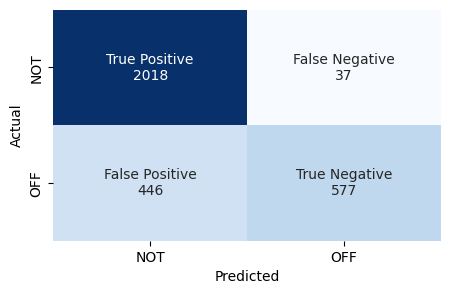

Computing different preformance metrics on valid  set of Dataset
Accuracy:  0.7454153182308522
Precision Score(macro:  0.7382318002462018
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7229638887636195
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       619
           1       0.70      0.40      0.51       308

    accuracy                           0.75       927
   macro avg       0.73      0.66      0.67       927
weighted avg       0.74      0.75      0.72       927



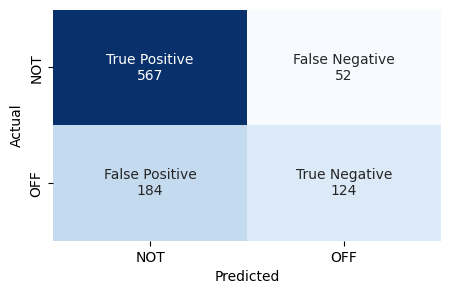

In [27]:
print('Train using of 25% of data')
model_25_file, vectorizer_25_file = train_method1(train_25_file, val_file, MODEL_1_25_DIRECTORY)

Let's train using 50% of data (train_50_file) and validate the model with the validation data (val_file). Save the model in the appropriate directory 

Train using of 50% of data
Training XGBClassifier
Cross Validation Mean:  0.7591831131582596
Saved model to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/50/model.sav
Saved Vectorizer to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/50/vectorizer.sav
Computing different preformance metrics on train  set of Dataset
Accuracy:  0.8264489795918367
Precision Score(macro:  0.8421443185674902
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.8112927032406709
              precision    recall  f1-score   support

           0       0.81      0.98      0.88      4089
           1       0.92      0.53      0.67      2036

    accuracy                           0.83      6125
   macro avg       0.86      0.75      0.78      6125
weighted avg       0.84      0.83      0.81      6125



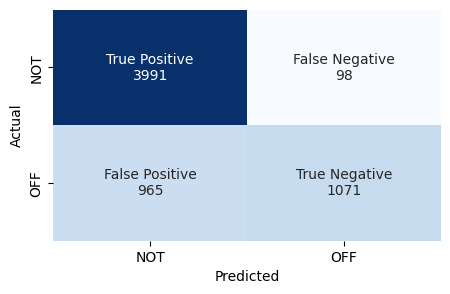

Computing different preformance metrics on valid  set of Dataset
Accuracy:  0.7594390507011867
Precision Score(macro:  0.756063432858562
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.738460595381554
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       619
           1       0.74      0.43      0.54       308

    accuracy                           0.76       927
   macro avg       0.75      0.68      0.69       927
weighted avg       0.76      0.76      0.74       927



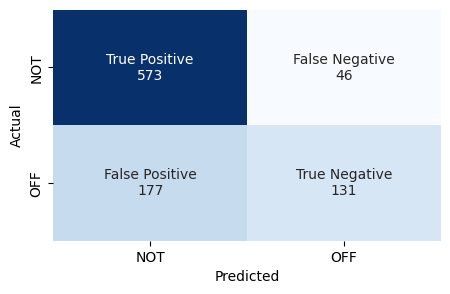

In [28]:
print('Train using of 50% of data')
model_50_file, vectorizer_50_file = train_method1(train_50_file, val_file, MODEL_1_50_DIRECTORY)

Let's train 75% of data (train_75_file)  and validate the model with the validation data (val_file). Save the model in the appropriate directory

Train using of 75% of data
Training XGBClassifier
Cross Validation Mean:  0.7680884212906371
Saved model to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/75/model.sav
Saved Vectorizer to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/75/vectorizer.sav
Computing different preformance metrics on train  set of Dataset
Accuracy:  0.821781104241241
Precision Score(macro:  0.8352788793733477
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.8065254838896097
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      6155
           1       0.90      0.52      0.66      3064

    accuracy                           0.82      9219
   macro avg       0.85      0.75      0.77      9219
weighted avg       0.84      0.82      0.81      9219



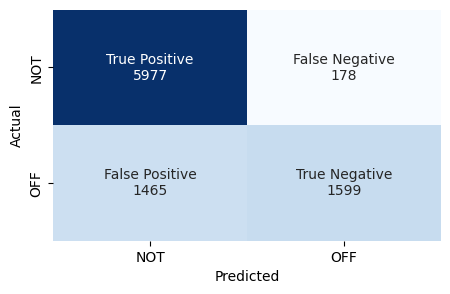

Computing different preformance metrics on valid  set of Dataset
Accuracy:  0.7810140237324703
Precision Score(macro:  0.7809706336833692
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7639978948922561
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       619
           1       0.78      0.47      0.59       308

    accuracy                           0.78       927
   macro avg       0.78      0.70      0.72       927
weighted avg       0.78      0.78      0.76       927



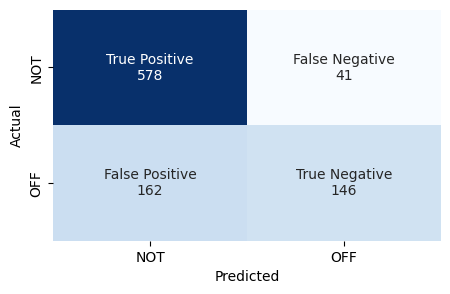

In [29]:
print('Train using of 75% of data')
model_75_file, vectorizer_75_file = train_method1(train_75_file, val_file, MODEL_1_75_DIRECTORY)

Training the model using 100% of data (train_100_file)  and validate the model with the validation data (val_file). Save the model in the appropriate directory

Train using of 100% of data
Training XGBClassifier
Cross Validation Mean:  0.7707313502906517
Saved model to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/100/model.sav
Saved Vectorizer to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/100/vectorizer.sav
Computing different preformance metrics on train  set of Dataset
Accuracy:  0.8171850889303988
Precision Score(macro:  0.8305340832281103
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.8011024535173706
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      8221
           1       0.89      0.51      0.65      4092

    accuracy                           0.82     12313
   macro avg       0.85      0.74      0.76     12313
weighted avg       0.83      0.82      0.80     12313



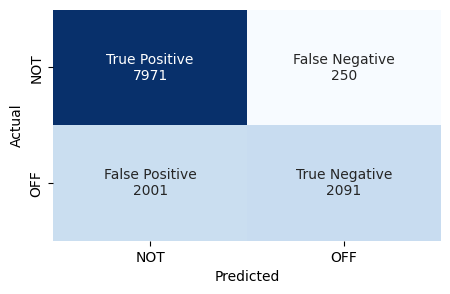

Computing different preformance metrics on valid  set of Dataset
Accuracy:  0.7734627831715211
Precision Score(macro:  0.7718127499722107
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.755650424550151
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       619
           1       0.76      0.46      0.57       308

    accuracy                           0.77       927
   macro avg       0.77      0.69      0.71       927
weighted avg       0.77      0.77      0.76       927



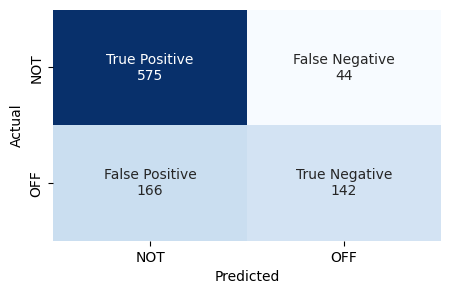

In [30]:
print('Train using of 100% of data')
model_100_file, vectorizer_100_file = train_method1(train_100_file, val_file, MODEL_1_100_DIRECTORY)

## Testing code
Your test code should be a stand alone code that must take `test_file`, `model_file` and `output_dir` as input. You could have other things as also input, but these three are must. You would load both files, and generate output based on inputs. Then you will `print` / `display`/ `plot` all performance metrics, and save the output file in the `output_dir`  

In [31]:
def test_method1(test_file, model_file, vectorizer_file, output_dir):
   
    test_df = pd.read_csv(test_file)
    #apply clean_tweet function to the tweet function
    test_df['tweet']=test_df.apply(clean_tweet, axis = 1)
    #apply stemming function to the tweet function
    test_df['tweet'] = test_df['tweet'].apply(stemming)
    
    test_label = test_df['label']
    test_label = test_label.replace({'NOT':0,'OFF':1})

    model, vectorizer = load_model1(model_file, vectorizer_file) 

    test_values= prepare_dataset1(test_df,vectorizer)

    test_pred_label = model.predict(test_values)

    cross_val = cross_val_score(model,test_values,test_pred_label, scoring = 'accuracy', cv = 10)
    print('Cross Validation Mean: ', cross_val.mean())

    test_df['out_label']  = test_pred_label # Note how this is saved 
    test_df['out_label'] = test_df['out_label'].replace({0:'NOT',1:'OFF'})
    test_f1_score = compute_performance(test_label, test_pred_label, split='test')

    out_file = os.path.join(output_dir, 'output_test.csv')

    print('Saving model output to', out_file)
    test_df.to_csv(out_file)

    
    # return 

Let's predict the label of the test data (test_file) with the model trained on 25% data. Save the output file in the appropriate directory.


Testing using model trained on 25% data
Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/25/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/25/vectorizer.sav
Cross Validation Mean:  0.9290697674418606
Computing different preformance metrics on test  set of Dataset
Accuracy:  0.8093023255813954
Precision Score(macro:  0.8113956569456677
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7853499380062451
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       620
           1       0.82      0.40      0.54       240

    accuracy                           0.81       860
   macro avg       0.81      0.69      0.71       860
weighted avg       0.81      0.81      0.79       860



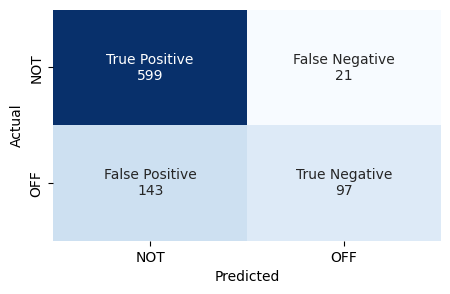

Saving model output to gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/25/output_test.csv


In [32]:
print('Testing using model trained on 25% data')
test_method1(test_file, model_25_file, vectorizer_25_file, MODEL_1_25_DIRECTORY)

Let's predict the label of the test data (test_file) with the model trained on 50% data. Save the output file in the appropriate directory

Testing using model trained on 50% data
Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/50/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/50/vectorizer.sav
Cross Validation Mean:  0.9151162790697676
Computing different preformance metrics on test  set of Dataset
Accuracy:  0.8093023255813954
Precision Score(macro:  0.8088530284745099
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7870731175938008
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       620
           1       0.81      0.42      0.55       240

    accuracy                           0.81       860
   macro avg       0.81      0.69      0.71       860
weighted avg       0.81      0.81      0.79       860



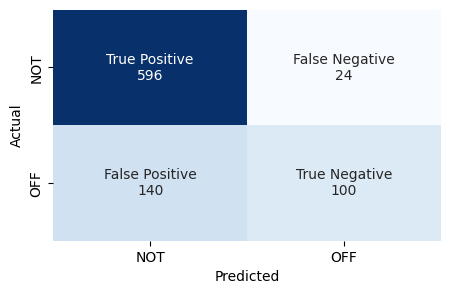

Saving model output to gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/50/output_test.csv


In [33]:
print('Testing using model trained on 50% data')
test_method1(test_file, model_50_file, vectorizer_50_file, MODEL_1_50_DIRECTORY)

Let's predict the label of the test data (test_file) with the model trained on 75% data. Save the output file in the appropriate directory

Testing using model trained on 75% data
Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/75/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/75/vectorizer.sav
Cross Validation Mean:  0.908139534883721
Computing different preformance metrics on test  set of Dataset
Accuracy:  0.8186046511627907
Precision Score(macro:  0.818541923193086
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7995396475231569
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       620
           1       0.82      0.45      0.58       240

    accuracy                           0.82       860
   macro avg       0.82      0.71      0.73       860
weighted avg       0.82      0.82      0.80       860



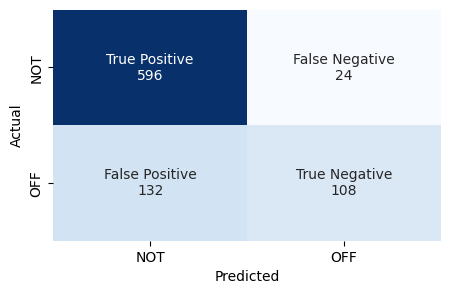

Saving model output to gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/75/output_test.csv


In [34]:
print('Testing using model trained on 75% data')
test_method1(test_file, model_75_file, vectorizer_75_file, MODEL_1_75_DIRECTORY)

Let's predict the label of the test data (test_file) with the model trained on 100% data. Save the output file in the appropriate directory

Testing using model trained on 100% data
Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/100/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/100/vectorizer.sav
Cross Validation Mean:  0.9116279069767443
Computing different preformance metrics on test  set of Dataset
Accuracy:  0.813953488372093
Precision Score(macro:  0.8123330158213878
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7943996384852888
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       620
           1       0.80      0.44      0.57       240

    accuracy                           0.81       860
   macro avg       0.81      0.70      0.73       860
weighted avg       0.81      0.81      0.79       860



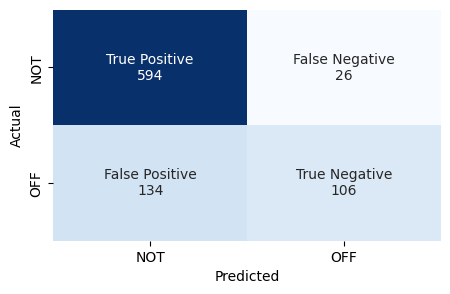

Saving model output to gdrive/MyDrive/./CE807/Assignment2/2209506/models/1/100/output_test.csv


In [35]:
print('Testing using model trained on 100% data')
test_method1(test_file, model_100_file, vectorizer_100_file, MODEL_1_100_DIRECTORY)

## Method 1 End


#Method 2

### 2.1: Install and import required modules

In [36]:
!pip install -q tensorflow-text

In [37]:
!pip install -q tf-models-official

In [38]:
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.12.0


In [39]:
import torch.optim as optim

In [40]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

### 2.2: Setting the output model directory and file names for model 2

In [41]:
MODEL_2_DIRECTORY = os.path.join(GOOGLE_DRIVE_PATH, 'models', '2') # Model 2 directory
print('Model 2 directory: ', MODEL_2_DIRECTORY)

MODEL_2_25_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'25') # Model 2 trained using 25% of train data directory
print('Model 2 directory with 25% data: ', MODEL_2_25_DIRECTORY)

MODEL_2_50_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'50') # Model 2 trained using 50% of train data directory
print('Model 2 directory with 50% data: ', MODEL_2_50_DIRECTORY)

MODEL_2_75_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'75') # Model 2 trained using 25% of train data directory
print('Model 2 directory with 75% data: ', MODEL_2_25_DIRECTORY)

MODEL_2_100_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'100') # Model 2 trained using 100% of train data directory
print('Model 2 directory with 100% data: ', MODEL_2_100_DIRECTORY)


model_2_25_output_test_file = os.path.join(MODEL_2_25_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 25% of train data 
print('Output file name using model 2 using 25% of train data: ',model_2_25_output_test_file)

model_2_50_output_test_file = os.path.join(MODEL_2_50_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 50% of train data 
print('Output file name using model 2 using 50% of train data: ',model_2_50_output_test_file)

model_2_75_output_test_file = os.path.join(MODEL_2_75_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 75% of train data 
print('Output file name using model 2 using 75% of train data: ',model_2_75_output_test_file)

model_2_100_output_test_file = os.path.join(MODEL_2_100_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 25% of train data 
print('Output file name using model 2 using 100% of train data: ',model_2_100_output_test_file)

Model 2 directory:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2
Model 2 directory with 25% data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25
Model 2 directory with 50% data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50
Model 2 directory with 75% data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25
Model 2 directory with 100% data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100
Output file name using model 2 using 25% of train data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25/output_test.csv
Output file name using model 2 using 50% of train data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50/output_test.csv
Output file name using model 2 using 75% of train data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/75/output_test.csv
Output file name using model 2 using 100% of train data:  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100/output_test.csv


### 2.3: Building the Model

In [42]:
class MultilayerPerceptron(nn.Module):

  def __init__(self, input_size, hidden_size, output_size,dropout_rate=0.2):
    # Call to the __init__ function of the super class
    super(MultilayerPerceptron, self).__init__()

    # Bookkeeping: Saving the initialization parameters
    self.input_size = input_size 
    self.hidden_size = hidden_size
    self.output_size = output_size 
    

    # Defining of our model
    self.model = nn.Sequential(
        nn.Linear(self.input_size, self.hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(self.hidden_size, self.output_size),
               
    )
    
  def forward(self, x):
    output = self.model(x)
    return output

In [43]:
torch.manual_seed(student_id)
torch.cuda.manual_seed(student_id)

In [44]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

###Checking GPU access

In [45]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

### 2.4: Preparing the dataset

In [46]:
def prepare_dataset(file_name, sample_flag=False,count_vectorizer=None):
  # Prepare the data
  data = pd.read_csv(file_name)
  #clean and stemming the tweet
  data['tweet'] = data.apply(clean_tweet,axis=1)
  data['tweet'] = data['tweet'].apply(stemming) 

  if count_vectorizer == None:
    count_vectorizer=CountVectorizer(stop_words='english',max_features=5000)
    #Vectorize the tweets
    values = count_vectorizer.fit_transform(data['tweet'].values)
  else:
    values = count_vectorizer.transform(data['tweet'].values)
  #convert the labels to numeric
  data['label'] = data['label'].replace({'NOT':0,'OFF':1})
  labels = data['label'].values

  # Convert into Tensor 
  values = torch.tensor(values.toarray()).float()
  labels = torch.tensor(labels)

  dataset = TensorDataset(values, labels)
  input_size = values.shape[1]
  output_size = labels.shape
  return dataset, input_size, count_vectorizer

Apply the prepare_dataset function on train_100_file and generate the train_loader

In [47]:
train_dataset, input_size, count_vectorizer = prepare_dataset(train_100_file,sample_flag=True)

batch_size = 64
shuffle = True

# Instantiate a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=shuffle) # In training always make shuffle True

###2.5: Initializing the model and optimizer

In [48]:
# Number of Epochs 
epochs = 10

# Define loss using a predefined loss function
loss_function = nn.CrossEntropyLoss()

# Initialize a model
input_size = input_size 
hidden_size = 2500
output_size = 2

model = MultilayerPerceptron(input_size=input_size,hidden_size=hidden_size, output_size=2,dropout_rate=0.2)
model = model.to(device)

# Define the optimizer
lr = 3e-5
# Remember your optimizer has to come after model definition 
optimizer = optim.Adam(model.parameters(), lr=lr)

###2.5.1:Print the model and its parameters and list the model's parameters





In [49]:
print(model)

MultilayerPerceptron(
  (model): Sequential(
    (0): Linear(in_features=5000, out_features=2500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=2500, out_features=2, bias=True)
  )
)


In [50]:
list(model.named_parameters())

[('model.0.weight',
  Parameter containing:
  tensor([[ 0.0087, -0.0011, -0.0138,  ...,  0.0120, -0.0101, -0.0131],
          [ 0.0087,  0.0134,  0.0032,  ...,  0.0017, -0.0046, -0.0008],
          [ 0.0050,  0.0120,  0.0103,  ..., -0.0062,  0.0130,  0.0084],
          ...,
          [ 0.0126, -0.0070, -0.0082,  ..., -0.0009, -0.0038, -0.0116],
          [-0.0121, -0.0044,  0.0089,  ...,  0.0040, -0.0035, -0.0014],
          [ 0.0094,  0.0084,  0.0033,  ...,  0.0050, -0.0028,  0.0066]],
         device='cuda:0', requires_grad=True)),
 ('model.0.bias',
  Parameter containing:
  tensor([-0.0106, -0.0045,  0.0131,  ..., -0.0124, -0.0063, -0.0078],
         device='cuda:0', requires_grad=True)),
 ('model.3.weight',
  Parameter containing:
  tensor([[ 0.0109, -0.0044,  0.0172,  ..., -0.0074,  0.0188, -0.0094],
          [ 0.0007, -0.0087,  0.0027,  ..., -0.0077,  0.0082, -0.0146]],
         device='cuda:0', requires_grad=True)),
 ('model.3.bias',
  Parameter containing:
  tensor([-0.0172,  

###2.6:Function for the labels of the data_loader

In [51]:
def labels(data_loader):
  all_data_labels = []
  all_predict_labels = []
  for i, batch in enumerate(data_loader):
    batch_inputs = batch[0].to(device)
    batch_labels = batch[1].to(device)
    
    outputs = model.forward(batch_inputs) # Remember you have probability here, need to get labels
    out_labels = torch.argmax(outputs, dim=1).detach()

    # Let's save both GT and Prected labels for the Acuracy, F1-Score Calculation 
    all_data_labels.extend(batch_labels.tolist())
    all_predict_labels.extend(out_labels.tolist())
    return all_data_labels,all_predict_labels

###2.7 Functions for saving and loading the model
- Saving the model function

In [52]:
def save_model2(model, vectorizer, model_dir):
    # save the model to disk
    model_file = os.path.join(model_dir, 'model.sav')
    pickle.dump(model, open(model_file, 'wb'))
    print('Saved model to ', model_file)
    vectorizer_file = os.path.join(model_dir, 'vectorizer.sav') 
    pickle.dump(vectorizer, open(vectorizer_file, 'wb'))
    print('Saved Vectorizer to ', vectorizer_file)
    return model_file, vectorizer_file 

- Function for Loading the model

In [53]:
def load_model2(model_file, vectorizer_file):
    # load model and vectorizer from disk
    model = pickle.load(open(model_file, 'rb'))
    print('Loaded model from ', model_file)
    vectorizer = pickle.load(open(vectorizer_file, 'rb'))
    print('Loaded Vectorizer from ', vectorizer_file)
    return model, vectorizer

### 2.8 Training method 2
- Call all epoch, train_loss, val_loss and print the line chart for train_loss vs epoch and val_loss vs epoch

In [54]:
def train_method2(loss_function, optimizer, model, data_loader,val_loader,num_epochs = epochs):
  train_losses = []
  val_losses = []
  for epoch in range(num_epochs):
  # Running the model on training data
    total_train_loss = 0
    for i, batch in enumerate(data_loader):
    # We could move whole data to GPU but it will take lots of space so only move one batch at a time
      batch_inputs = batch[0].to(device)
      batch_labels = batch[1].to(device)
      optimizer.zero_grad()
      outputs = model.forward(batch_inputs)
      loss = loss_function(outputs, batch_labels)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()
    epoch_train_loss = total_train_loss / len(data_loader)
    train_losses.append(epoch_train_loss)
    #for valdation data
    total_val_loss = 0
    for i, batch in enumerate(val_loader):
      batch_inputs = batch[0].to(device)
      batch_labels = batch[1].to(device)
      optimizer.zero_grad()
      outputs = model.forward(batch_inputs)
      loss = loss_function(outputs, batch_labels)
      loss.backward()
      optimizer.step()
      total_val_loss += loss.item()
    epoch_val_loss = total_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

   
    # Plot the training and validation losses against the number of epochs
  plt.figure(figsize = (5,3))
  plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses vs. Epoch')
  plt.legend()
  plt.tight_layout()
  plt.show()

  return train_losses, val_losses

### 2.9 Function to Validate the models on validation data (val_file)

In [55]:
def val_method2(val_file, model_file, vectorizer_file):
   
    val_df = pd.read_csv(val_file)
    #apply clean_tweet function to the tweet function
    val_df['tweet']=val_df.apply(clean_tweet, axis = 1)
    #apply stemming function to the tweet function
    val_df['tweet'] = val_df['tweet'].apply(stemming)
    
    val_label = val_df['label']
    val_label = val_label.replace({'NOT':0,'OFF':1})

    model, vectorizer = load_model2(model_file, vectorizer_file) 

    val_dataset, c , _ = prepare_dataset(val_file,sample_flag=True,count_vectorizer=count_vectorizer)
    val_loader = DataLoader(val_dataset, batch_size=927,shuffle=False)
    val_labels = labels(val_loader)
    metrics = compute_performance(val_labels[0],val_labels[1],split = 'validation')

    return metrics

###2.10: Computing the training_loss and the val_loss for different data sizes
- Compute the metrics of the model on val_data

Prepare the valid data

In [56]:
# Load valid Data
val_dataset, c , _ = prepare_dataset(val_file,sample_flag=True,count_vectorizer=count_vectorizer)

# Instantiate a DataLoader
# in practice you need to keep shuffle false at the testing time, so that you could easily match data with predicted label
val_loader = DataLoader(val_dataset, batch_size=927,shuffle=False) 

### 2.10.1: 25% Data Size

Prepare 25% training data 

In [57]:
train_25, input_size, count_vectorizer = prepare_dataset(train_25_file,sample_flag=True)

batch_size = 64
shuffle = True

# Instantiate a DataLoader
train_25_loader = DataLoader(train_25, batch_size=batch_size,shuffle=shuffle)
train_25_labels = labels(train_25_loader)

Train and save the model with train_25_file

Start
Epoch 1/10, Training Loss: 0.6884, Validation Loss: 0.6844
Epoch 2/10, Training Loss: 0.6679, Validation Loss: 0.6717
Epoch 3/10, Training Loss: 0.6514, Validation Loss: 0.6606
Epoch 4/10, Training Loss: 0.6321, Validation Loss: 0.6516
Epoch 5/10, Training Loss: 0.6136, Validation Loss: 0.6430
Epoch 6/10, Training Loss: 0.5964, Validation Loss: 0.6347
Epoch 7/10, Training Loss: 0.5733, Validation Loss: 0.6276
Epoch 8/10, Training Loss: 0.5507, Validation Loss: 0.6200
Epoch 9/10, Training Loss: 0.5278, Validation Loss: 0.6121
Epoch 10/10, Training Loss: 0.5062, Validation Loss: 0.6049


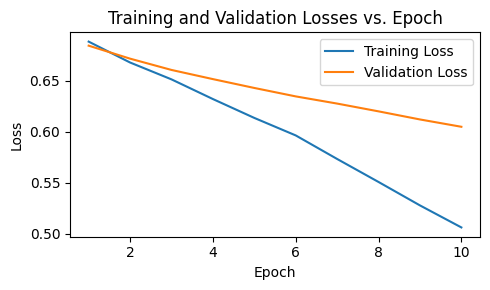

End
Saved model to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25/model.sav
Saved Vectorizer to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25/vectorizer.sav


In [58]:
print('Start')
# print(list(model.parameters()))

train_method2(loss_function, optimizer, model, train_25_loader,val_loader, num_epochs=epochs)

print('End')
model_25_file, vectorizer_25_file = save_model2(model, count_vectorizer, MODEL_2_25_DIRECTORY)

Compute performance metrics of model_25 on val_file

Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25/vectorizer.sav
Computing different preformance metrics on validation  set of Dataset
Accuracy:  0.6752966558791802
Precision Score(macro:  0.7056145589849995
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.5573368051426751
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       619
           1       0.77      0.03      0.06       308

    accuracy                           0.68       927
   macro avg       0.72      0.51      0.43       927
weighted avg       0.71      0.68      0.56       927



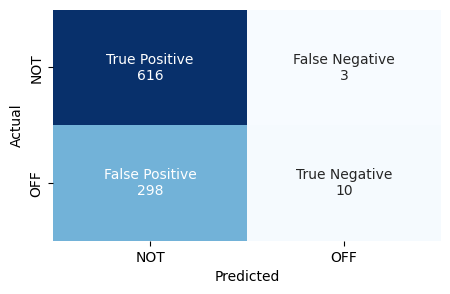

In [59]:
val_method2(val_file, model_25_file,vectorizer_25_file)

### 2.10.2: 50% Data Size

Prepare 50% training data 

In [60]:
train_50, input_size, count_vectorizer = prepare_dataset(train_50_file,sample_flag=True)

batch_size = 64
shuffle = True

# Instantiate a DataLoader
train_50_loader = DataLoader(train_50, batch_size=batch_size,shuffle=shuffle) # In training always make shuffle True
train_50_labels = labels(train_50_loader)

Train and save the model with train_50_file

Start
Epoch 1/10, Training Loss: 0.6379, Validation Loss: 0.5968
Epoch 2/10, Training Loss: 0.5889, Validation Loss: 0.5903
Epoch 3/10, Training Loss: 0.5520, Validation Loss: 0.5841
Epoch 4/10, Training Loss: 0.5168, Validation Loss: 0.5772
Epoch 5/10, Training Loss: 0.4822, Validation Loss: 0.5719
Epoch 6/10, Training Loss: 0.4491, Validation Loss: 0.5673
Epoch 7/10, Training Loss: 0.4187, Validation Loss: 0.5625
Epoch 8/10, Training Loss: 0.3901, Validation Loss: 0.5561
Epoch 9/10, Training Loss: 0.3641, Validation Loss: 0.5539
Epoch 10/10, Training Loss: 0.3407, Validation Loss: 0.5490


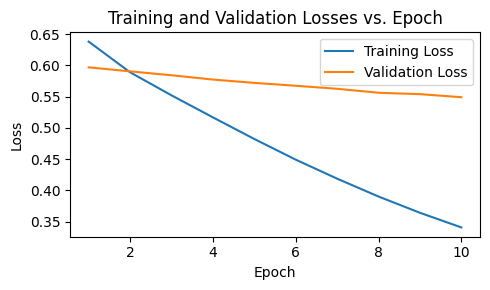

End
Saved model to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50/model.sav
Saved Vectorizer to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50/vectorizer.sav


In [61]:
print('Start')
# print(list(model.parameters()))

train_method2(loss_function, optimizer, model, train_50_loader, val_loader, num_epochs=epochs)

print('End')

model_50_file, vectorizer_50_file = save_model2(model, count_vectorizer, MODEL_2_50_DIRECTORY)

Compute the performance metrics of model_50 on val_file

Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50/vectorizer.sav
Computing different preformance metrics on validation  set of Dataset
Accuracy:  0.7400215749730313
Precision Score(macro:  0.7302511157429641
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7193379285598528
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       619
           1       0.68      0.41      0.51       308

    accuracy                           0.74       927
   macro avg       0.72      0.66      0.67       927
weighted avg       0.73      0.74      0.72       927



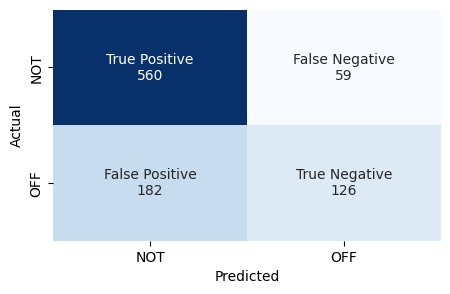

In [62]:
val_method2(val_file, model_50_file,vectorizer_50_file)

### 2.10.3: 75% Data Size

Prepare 75% training data 

In [63]:
train_75, input_size, count_vectorizer = prepare_dataset(train_75_file,sample_flag=True)

batch_size = 64
shuffle = True

# Instantiate a DataLoader
train_75_loader = DataLoader(train_75, batch_size=batch_size,shuffle=shuffle)

In [64]:
train_75_labels = labels(train_75_loader)

Train and save the model with train_75_file

Start
Epoch 1/10, Training Loss: 0.6600, Validation Loss: 0.5311
Epoch 2/10, Training Loss: 0.5490, Validation Loss: 0.5278
Epoch 3/10, Training Loss: 0.5007, Validation Loss: 0.5251
Epoch 4/10, Training Loss: 0.4629, Validation Loss: 0.5257
Epoch 5/10, Training Loss: 0.4316, Validation Loss: 0.5252
Epoch 6/10, Training Loss: 0.4033, Validation Loss: 0.5250
Epoch 7/10, Training Loss: 0.3795, Validation Loss: 0.5265
Epoch 8/10, Training Loss: 0.3597, Validation Loss: 0.5248
Epoch 9/10, Training Loss: 0.3357, Validation Loss: 0.5272
Epoch 10/10, Training Loss: 0.3178, Validation Loss: 0.5291


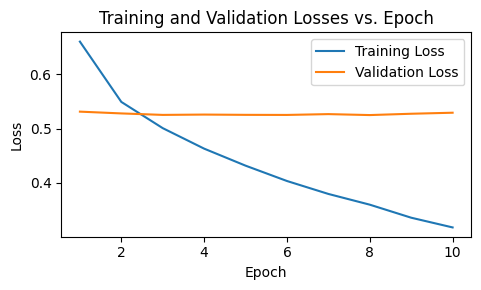

End
Saved model to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/75/model.sav
Saved Vectorizer to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/75/vectorizer.sav


In [65]:
print('Start')
# print(list(model.parameters()))

train_method2(loss_function, optimizer, model, train_75_loader,val_loader, num_epochs=epochs)

print('End')
model_75_file, vectorizer_75_file = save_model2(model, count_vectorizer, MODEL_2_75_DIRECTORY)

Compute the performance metrics of model_75 on val_file 

Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/75/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/75/vectorizer.sav
Computing different preformance metrics on validation  set of Dataset
Accuracy:  0.7443365695792881
Precision Score(macro:  0.7341188786225369
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7289089331506147
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       619
           1       0.67      0.45      0.54       308

    accuracy                           0.74       927
   macro avg       0.72      0.67      0.68       927
weighted avg       0.73      0.74      0.73       927



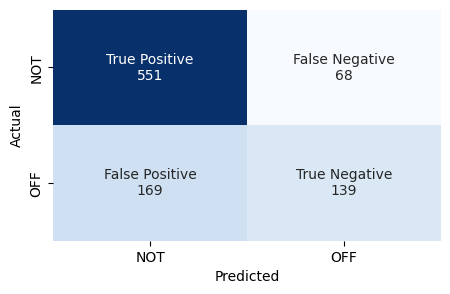

In [66]:
val_method2(val_file, model_75_file,vectorizer_75_file)

### 2.10.4: 100% Data Size

Prepare 100% training data

In [67]:
train_dataset, input_size, count_vectorizer = prepare_dataset(train_100_file,sample_flag=True)

batch_size = 64
shuffle = True

# Instantiate a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=shuffle) # In training always make shuffle True

In [68]:
train_100_labels = labels(train_loader)

Train and save the model with train_100_file

Start
Epoch 1/10, Training Loss: 0.6530, Validation Loss: 0.4483
Epoch 2/10, Training Loss: 0.5292, Validation Loss: 0.4350
Epoch 3/10, Training Loss: 0.4788, Validation Loss: 0.4284
Epoch 4/10, Training Loss: 0.4430, Validation Loss: 0.4246
Epoch 5/10, Training Loss: 0.4136, Validation Loss: 0.4224
Epoch 6/10, Training Loss: 0.3887, Validation Loss: 0.4210
Epoch 7/10, Training Loss: 0.3658, Validation Loss: 0.4174
Epoch 8/10, Training Loss: 0.3450, Validation Loss: 0.4194
Epoch 9/10, Training Loss: 0.3258, Validation Loss: 0.4218
Epoch 10/10, Training Loss: 0.3080, Validation Loss: 0.4201


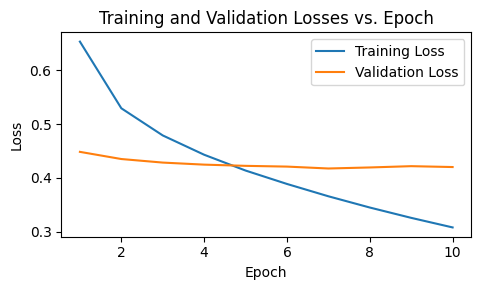

End
Saved model to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100/model.sav
Saved Vectorizer to  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100/vectorizer.sav


In [69]:
print('Start')
# print(list(model.parameters()))

train_method2(loss_function, optimizer, model, train_loader,val_loader, num_epochs=epochs)

print('End')
model_100_file, vectorizer_100_file = save_model2(model, count_vectorizer, MODEL_2_100_DIRECTORY)

Compute the performance metrics for model_100_file on val_file

Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100/vectorizer.sav
Computing different preformance metrics on validation  set of Dataset
Accuracy:  0.7993527508090615
Precision Score(macro:  0.7950933751698038
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7915885942311409
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       619
           1       0.76      0.58      0.66       308

    accuracy                           0.80       927
   macro avg       0.79      0.74      0.76       927
weighted avg       0.80      0.80      0.79       927



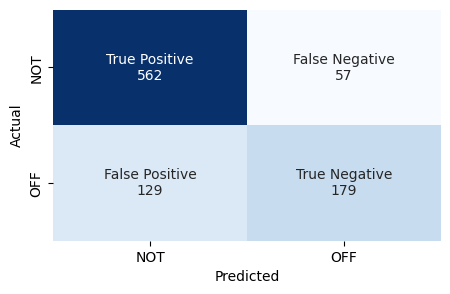

In [70]:
val_method2(val_file, model_100_file,vectorizer_100_file)

### 2.11: Predictions

Let's see how well our model is making predictions. We can start by creating our test data.

Prepare the test data

In [71]:
# Load test Data
test_dataset, c , _ = prepare_dataset(test_file,sample_flag=True,count_vectorizer=count_vectorizer)

# Instantiate a DataLoader
# in practice you need to keep shuffle false at the testing time, so that you could easily match data with predicted label
test_loader = DataLoader(test_dataset, batch_size=860,shuffle=False) 

Function to test the model

In [72]:
def test_method2(test_file, model_file, vectorizer_file, output_dir):
   
    test_df = pd.read_csv(test_file)
    #apply clean_tweet function to the tweet function
    test_df['tweet']=test_df.apply(clean_tweet, axis = 1)
    #apply stemming function to the tweet function
    test_df['tweet'] = test_df['tweet'].apply(stemming)
    
    test_label = test_df['label']
    test_label = test_label.replace({'NOT':0,'OFF':1})

    model, vectorizer = load_model2(model_file, vectorizer_file) 

    test_dataset, c , _ = prepare_dataset(test_file,sample_flag=True,count_vectorizer=count_vectorizer)
    test_loader = DataLoader(test_dataset, batch_size=860,shuffle=False)
    test_labels = labels(test_loader)
    predictions=[]
    for inputs, _ in test_loader:
      outputs = model(inputs.cuda())
      _, batch_preds = torch.max(outputs, dim=1)
      predictions.extend(batch_preds.tolist())
    
    test_df['out_label']  = predictions 
    test_df['out_label'] = test_df['out_label'].replace({0:'NOT',1:'OFF'})
    test_metrics = compute_performance(test_labels[0], predictions)

    out_file = os.path.join(output_dir, 'output_test.csv')

    print('Saving model output to', out_file)
    test_df.to_csv(out_file)

    

### 2.11.1: Test train_25_file model on test data

Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25/vectorizer.sav
Computing different preformance metrics on test  set of Dataset
Accuracy:  0.7209302325581395
Precision Score(macro:  0.519740400216333
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.6040226272784412
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       620
           1       0.00      0.00      0.00       240

    accuracy                           0.72       860
   macro avg       0.36      0.50      0.42       860
weighted avg       0.52      0.72      0.60       860



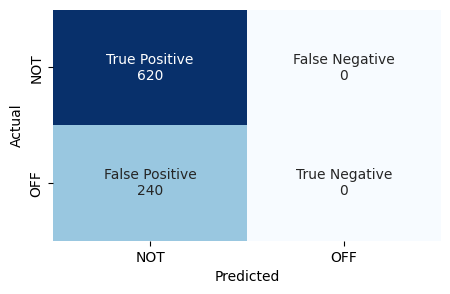

Saving model output to gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/25/output_test.csv


In [73]:
test_method2(test_file,model_25_file,vectorizer_25_file,MODEL_2_25_DIRECTORY)

### 2.11.2: Test train_50_file model on test data

Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50/vectorizer.sav
Computing different preformance metrics on test  set of Dataset
Accuracy:  0.7034883720930233
Precision Score(macro:  0.6149236695676986
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.6221964440312353
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       620
           1       0.33      0.06      0.11       240

    accuracy                           0.70       860
   macro avg       0.53      0.51      0.46       860
weighted avg       0.61      0.70      0.62       860



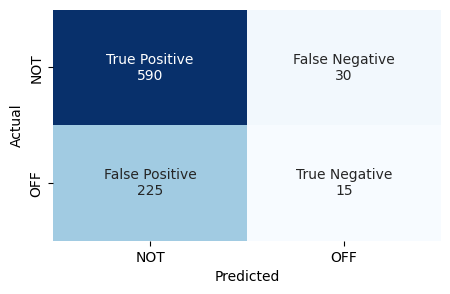

Saving model output to gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/50/output_test.csv


In [74]:
test_method2(test_file,model_50_file,vectorizer_50_file,MODEL_2_50_DIRECTORY)

### 2.11.3: Test train_75_file model on test data

Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/75/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/75/vectorizer.sav
Computing different preformance metrics on test  set of Dataset
Accuracy:  0.7011627906976744
Precision Score(macro:  0.6460748314013488
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.6521321693104455
              precision    recall  f1-score   support

           0       0.74      0.91      0.81       620
           1       0.41      0.16      0.23       240

    accuracy                           0.70       860
   macro avg       0.57      0.54      0.52       860
weighted avg       0.65      0.70      0.65       860



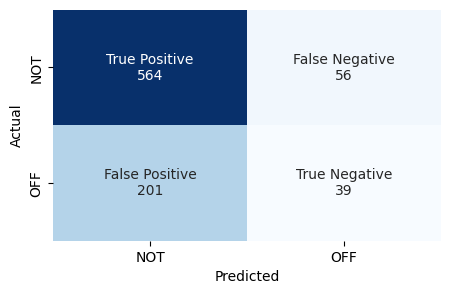

Saving model output to gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/75/output_test.csv


In [75]:
test_method2(test_file,model_75_file,vectorizer_75_file,MODEL_2_75_DIRECTORY)

### 2.11.4: Test train_100_file model on test data

Loaded model from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100/model.sav
Loaded Vectorizer from  gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100/vectorizer.sav
Computing different preformance metrics on test  set of Dataset
Accuracy:  0.791860465116279
Precision Score(macro:  0.7804942030710489
Recall score(macro):  <function recall_score at 0x7f1ea5064280>
F1 Score(macro):  0.7798746232648397
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       620
           1       0.68      0.48      0.56       240

    accuracy                           0.79       860
   macro avg       0.75      0.70      0.71       860
weighted avg       0.78      0.79      0.78       860



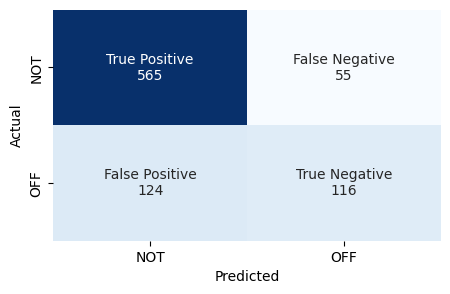

Saving model output to gdrive/MyDrive/./CE807/Assignment2/2209506/models/2/100/output_test.csv


In [76]:
test_method2(test_file,model_100_file,vectorizer_100_file,MODEL_2_100_DIRECTORY)